In [1]:
using PyPlot
include("Util.jl")
using .Util;

In [2]:
srand(0);

In [3]:
function power_iter(A, x, alpha, steps)
    mu = Float64[]
    ang = Float64[]
    push!(mu, rayleigh_quotient(A, x))
    push!(ang, get_angle(v1,x))
    for t = 2:steps
        x = alpha * x + A * x
        x /= norm(x)
        push!(mu, rayleigh_quotient(A, x))
        push!(ang, get_angle(v1, x))
    end
    return mu, ang
end

power_iter (generic function with 1 method)

In [4]:
function chebyshev(A, x, x0, beta, steps)
    mu = Float64[]
    ang = Float64[]
    push!(mu, rayleigh_quotient(A, x0))
    push!(ang, get_angle(v1, x0))
    for t = 2:steps
        (x, x0) = (A * x - beta * x0, x)
        Z = norm(x)
        x /= Z
        x0 /= Z
        push!(mu, rayleigh_quotient(A, x0))
        push!(ang, get_angle(v1, x0))
    end
    return mu, ang
end

chebyshev (generic function with 1 method)

In [5]:
function run_opt_legendre(A_sample, w0, lambda, steps)
    r = 1/2
    p0 = 1/sqrt(2)*w0
    x = A_sample()
    p1 = x/sqrt(2/3)*w0
    l0 = 1/sqrt(2)
    l1 = lambda/sqrt(2/3)
    f0 = w0
    mu = Float64[]
    ang = Float64[]
    for i = 1:steps
        f = (f0 * r + l1 * p1)/(r+l1^2)
        push!(mu, rayleigh_quotient(A, f0))
        push!(ang, get_angle(v1, f0))
        x = A_sample()
        p1, p0 = (2i + 1)/(i+1) * sqrt((2i+3)/(2i+1)) * x * p1 - i/(i+1)*sqrt((2i+3)/(2i-1))*p0, p1
        l1, l0 = (2i + 1)/(i+1) * sqrt((2i+3)/(2i+1)) * lambda * l1 - i/(i+1)*sqrt((2i+3)/(2i-1))*l0, l1
        r = r + l0^2
        f0 = f
    end
    return mu, ang
end

run_opt_legendre (generic function with 1 method)

In [6]:
function lanczos_iter(A,q,max_iters)
    q = q/norm(q)
    n = size(A,1)
    max_iters = minimum([max_iters, n])
    Q = zeros(Float64,n, max_iters+1)
    T = zeros(Float64,max_iters+1, max_iters+1)
    mu = Float64[]
    ang = Float64[]
    beta0 = 0;
    q0 = zeros(n)
    for i in 1:max_iters
        Q[:,i] = q;
        v = A*q;
        T[i,i] = dot(q,v);
        r = v - beta0*q0 - T[i,i]*q
        beta0 = norm(r)
        T[i,i+1] = beta0
        T[i+1,i] = beta0
        q0 = q;
        q = r/beta0;
        eig_vals, eig_vec = eig(T[1:i,1:i])
        x = Q[:,1:i]*eig_vec[:,i]
        push!(mu, eig_vals[i])
        push!(ang, get_angle(v1, x))
    end
    return mu, ang
end

lanczos_iter (generic function with 1 method)

In [7]:
n = 500
lambda1 = 1.0001
eigenvalues = [linspace(-1, 1, n - 1); lambda1]
(A, v1) = get_random_matrix(eigenvalues);

In [8]:
x0 = randn(n)
x = A * x0;
x0 /= norm(x0)
x /= norm(x);

In [9]:
steps = 1000
steps2 = 400
mu_pi, ang_pi = power_iter(A, x, 0, steps)
mu_chebyshev, ang_chebyshev = chebyshev(A, x, x0, 0.25, steps)
mu_test, ang_test = run_opt_legendre(() -> A, x0, 1, steps)
mu_lanczos, ang_lanczos = lanczos_iter(A,x0,steps2);

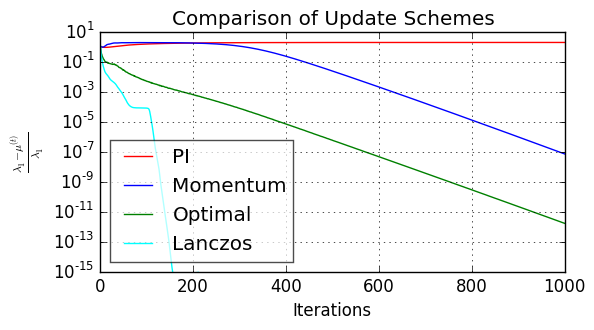

In [10]:
figure(figsize=(6,3))

semilogy(1:steps, abs(lambda1 - mu_pi), label="PI", color="red")
semilogy(1:steps, abs(lambda1 - mu_chebyshev), label="Momentum", color="blue")
semilogy(1:steps, abs(lambda1 - mu_test), label="Optimal", color="green")
semilogy(1:steps2, abs(lambda1 - mu_lanczos), label="Lanczos", color="cyan")

title("Comparison of Update Schemes")
xlabel("Iterations")
ylabel(L"\frac{\lambda_1 - \mu^{(t)}}{\lambda_1}")
legend(loc="best",framealpha=0.7)
grid("on")
ylim([1e-15, 10])
savefig("Inhomogeneous1.pdf", bbox_inches="tight")

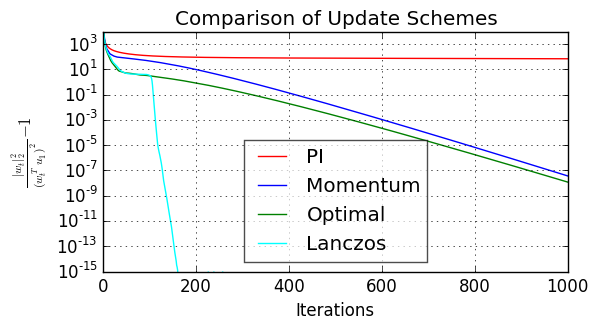

In [11]:
figure(figsize=(6,3))

semilogy(1:steps, ang_pi, label="PI", color="red")
semilogy(1:steps, ang_chebyshev, label="Momentum", color="blue")
semilogy(1:steps, ang_test, label="Optimal", color="green")
semilogy(1:steps2, ang_lanczos, label="Lanczos", color="cyan")

title("Comparison of Update Schemes")
xlabel("Iterations")
ylabel(L"\frac{\|w_t\|_2^2}{(w_t^Tu_1)^2} - 1")
ylim([1e-15, 1e4])
grid("on")
legend(loc="best",framealpha=0.7)
savefig("Inhomogeneous2.pdf", bbox_inches="tight")